In [1]:
#importing necessary libraries
import math
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
xls = pd.ExcelFile("../data/pwt100.xlsx")
all_df = pd.read_excel(xls, "Data")

In [3]:
alpha = 0.3

#Get relevant variables for Brazil
data_tfp = all_df.loc[all_df["country"] == "Brazil", ("year", "rgdpna", "rnna", "rtfpna", "hc", "emp", "avh", "csh_i", "delta")]
data_tfp["labour"] = data_tfp["emp"]*data_tfp["avh"]

#Extract TFP
data_tfp["tfp"] = data_tfp["rgdpna"] / (data_tfp["rnna"]**alpha*(data_tfp["hc"]*data_tfp["labour"])**(1-alpha))
    

In [4]:
ln_data_tfp= data_tfp.drop(columns='year').apply(np.log)
ln_data_tfp['year'] = data_tfp['year']

           K contribution  L contribution  H contribution  A contribution  \
year                                                                        
1950-1964        0.250914        0.312187        0.073808        0.363091   
1964-1980        0.303890        0.266667        0.016336        0.413107   
1980-1994        0.540495        0.806976        0.567948       -0.915419   
1994-2019        0.304646        0.405575        0.657598       -0.367818   

           Y annual growth rate  
year                             
1950-1964              0.068373  
1964-1980              0.078859  
1980-1994              0.018654  
1994-2019              0.022297  


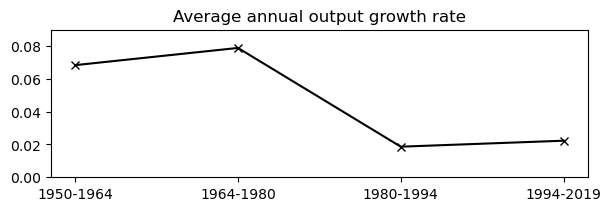

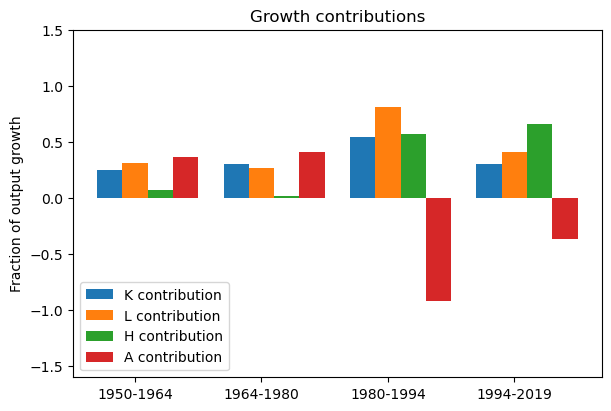

In [5]:
# Compute yearly intervals of the form "1950-1964"
period_intvls = np.array([f"{y1}-{y2}" for y1, y2 in zip([1950,1964,1980,1994,2019][:-1], [1950,1964,1980,1994,2019][1:])])

period_change = ln_data_tfp[ln_data_tfp["year"].isin([1950,1964,1980,1994,2019])][["rgdpna", "tfp", "rnna", "hc", "labour"]].diff().iloc[1:,:]


# Multiply log changes of each variable by different scalars according to the production function to obtain their growth contributions
mul_dict={"tfp":1, "rnna":alpha, "hc":(1-alpha), "labour":(1-alpha)}


# period_contr is the growth contribution of each variable in each period
# rearrange the columns the way we want them
period_contr = period_change.drop(columns = "rgdpna").mul(mul_dict).divide(period_change["rgdpna"], axis=0).reindex(columns = ["rnna", "labour", "hc", "tfp"])

# Annualize Y growth rate
period_to_annual_Y = np.array([rate/years for rate, years in zip(period_change["rgdpna"], [1964-1950, 1980-1964, 1994-1980, 2019-1994])])


# Put together the dataframe of the contribution of each factor to growth
df_period_contr = pd.DataFrame(data = np.hstack((period_intvls[:, None], 
                                           period_contr.to_numpy(), 
                                           period_to_annual_Y[:, None])),
                            columns = ['year', 'K contribution', 'L contribution', 'H contribution', 'A contribution', 'Y annual growth rate'])

                            # Set index
df_period_contr = df_period_contr.set_index('year')

# Specify data type as float64
df_period_contr = df_period_contr.astype("float64")

print(df_period_contr)

x = np.arange(len(period_intvls))  # the label locations

fig, ax1 = plt.subplots(layout='constrained', figsize=(6, 2))
ax1.set_title('Average annual output growth rate')
ax1.plot(x, df_period_contr["Y annual growth rate"], color='black', marker='x', label='Y growth rate')
ax1.set_xticks(x, period_intvls)
ax1.set_ylim(0, 0.09)

width = 0.2  # the width of the bars
multiplier = 0

fig, ax2 = plt.subplots(layout='constrained', figsize=(6, 4))

for factor, contr in df_period_contr.drop(columns = "Y annual growth rate").to_dict("list").items():
    offset = width * multiplier
    rects = ax2.bar(x + offset, contr, width, label=factor)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title('Growth contributions')
ax2.set_ylabel('Fraction of output growth')
ax2.set_xticks(x + width, period_intvls)
ax2.legend(loc='lower left', ncols=1)
ax2.set_ylim(-1.6, 1.5)

plt.show()

           Y annual growth rate  K annual growth rate  L annual growth rate  \
year                                                                          
1950-1964              0.068373              0.057186              0.030493   
1964-1980              0.078859              0.079881              0.030041   
1980-1994              0.018654              0.033607              0.021504   
1994-2019              0.022297              0.022642              0.012918   

           H annual growth rate  A annual growth rate  
year                                                   
1950-1964              0.007209              0.024825  
1964-1980              0.001840              0.032577  
1980-1994              0.015135             -0.017076  
1994-2019              0.020946             -0.008201  


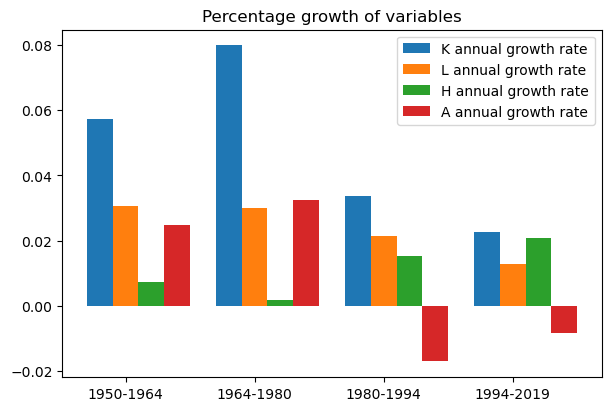

In [6]:
# Compute annual growth rates of factors
period_annual_change_prep = pd.concat([period_change.iloc[0:1]*(1/14), period_change.iloc[1:2]*(1/16), period_change.iloc[2:3]*(1/14), period_change.iloc[3:4]*(1/25)], axis = 0)

period_annual_change = period_annual_change_prep['rgdpna'].to_frame().rename(columns = {'rgdpna':'Y annual growth rate'})
period_annual_change['K annual growth rate'] = period_annual_change_prep['rnna']
period_annual_change['L annual growth rate'] = period_annual_change_prep['labour']
period_annual_change['H annual growth rate'] = period_annual_change_prep['hc']
period_annual_change['A annual growth rate'] = period_annual_change_prep['tfp']
period_annual_change['year'] = period_intvls

period_annual_change = period_annual_change.set_index('year')

print(period_annual_change)

width = 0.2  # the width of the bars
multiplier = 0

fig, ax2 = plt.subplots(layout='constrained', figsize=(6, 4))

for factor, change in period_annual_change.drop(columns = "Y annual growth rate").to_dict("list").items():
    offset = width * multiplier
    rects = ax2.bar(x + offset, change, width, label=factor)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title('Percentage growth of variables')
ax2.set_xticks(x + width, period_intvls)
ax2.legend(ncols=1)

plt.show()